In [27]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
train_df = pd.read_csv(r'D:\AYA\test_file\xgboost\train.csv')
test_df = pd.read_csv(r'D:\AYA\test_file\xgboost\test.csv')


# review data

In [26]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [2]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B056AF5548>,
      dtype=object)

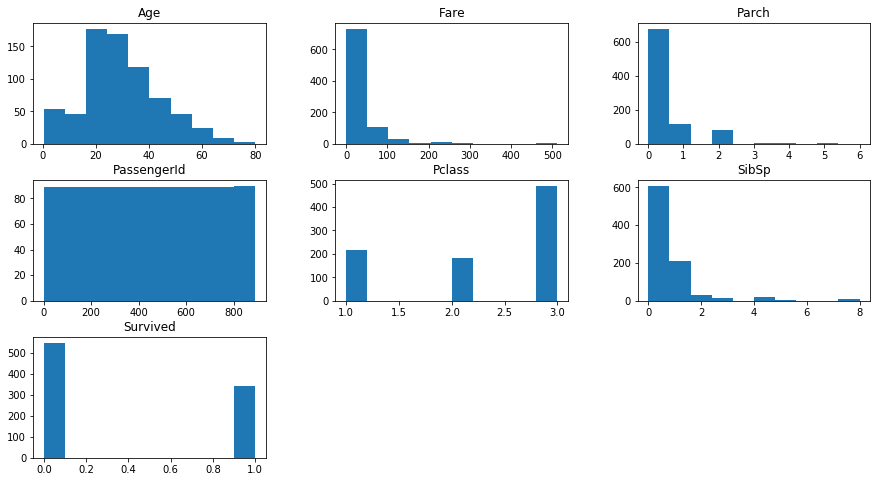

In [3]:
train_df.hist(bins=10,figsize=(15,8),grid=False)

In [94]:
# review status
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

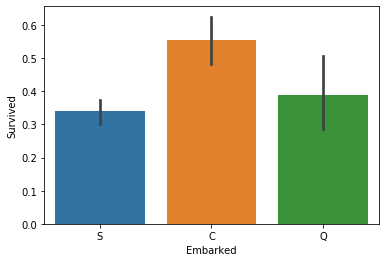

In [29]:
sns.barplot(data=train_df,x='Embarked',y='Survived')

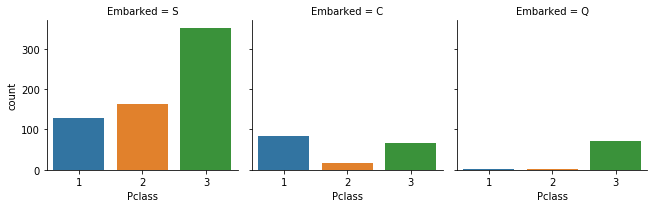

In [30]:
sns.catplot('Pclass',col='Embarked',data=train_df,kind='count',height=3)

In [25]:
# review status
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [35]:
# 挑選背景相同的其他乘客資料來補
full=train_df.append(test_df,ignore_index=True)
fill_fare = full[(full['Pclass']==3)&(full['Embarked']=='C')&(full['Cabin'].isnull())]['Fare'].mean()


## review feature

In [5]:
# 旅客頭銜找階級
full['Title']=full['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
full['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
the Countess      1
Mme               1
Sir               1
Capt              1
Jonkheer          1
Don               1
Dona              1
Lady              1
Name: Title, dtype: int64

In [6]:
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'

full['Title']=full['Title'].map(TitleDict)
full['Title'].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

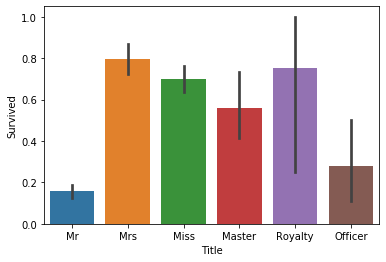

In [40]:
# 看頭銜跟生存的關係
sns.barplot(data=full,x='Title',y='Survived')

In [7]:
full['familyNum']=full['Parch']+full['SibSp']+1
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2

full['familySize']=full['familyNum'].map(familysize)
full['familySize'].value_counts()

0    790
1    437
2     82
Name: familySize, dtype: int64

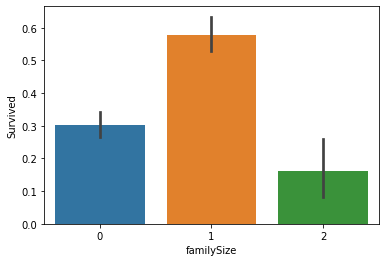

In [42]:
# 家庭大小對生存關係
sns.barplot(data=full,x='familySize',y='Survived')

In [44]:
full['Cabin']

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1304     NaN
1305    C105
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

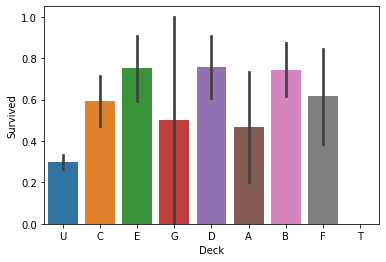

In [45]:
#  Cabin客艙類型 Cabin的首字母代表客艙的類型
full['Cabin']=full['Cabin'].fillna('U')
full['Deck']=full['Cabin'].map(lambda x:x[0])
sns.barplot(data=full,x='Deck',y='Survived')

In [48]:
# 同一票號的乘客數量可能不同
full['Ticket'].value_counts()

CA. 2343           11
1601                8
CA 2144             8
347082              7
PC 17608            7
                   ..
C.A. 33111          1
349214              1
SOTON/OQ 392076     1
349224              1
28666               1
Name: Ticket, Length: 929, dtype: int64

In [49]:
TickCountDict=full['Ticket'].value_counts()
TickCountDict

CA. 2343           11
1601                8
CA 2144             8
347082              7
PC 17608            7
                   ..
C.A. 33111          1
349214              1
SOTON/OQ 392076     1
349224              1
28666               1
Name: Ticket, Length: 929, dtype: int64

In [50]:
# 將只有一個的票種都改為1 以此類推
full['TickCot']=full['Ticket'].map(TickCountDict)
full['TickCot']

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64

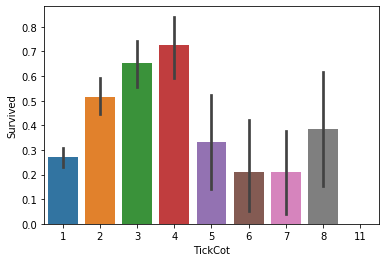

In [56]:
sns.barplot(data=full,x='TickCot',y='Survived')

# Clean data

In [133]:
# clean data
train_df = pd.read_csv(r'D:\AYA\test_file\xgboost\train.csv')
test_df = pd.read_csv(r'D:\AYA\test_file\xgboost\test.csv')

# 把數據劃分成等距區間 Fare
bins = 10

# 依照家庭大小來改
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2

# 配種再分群
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else :
        return 2

def Child_(num):
    if (num<=12):
        return 1    
    else:
        return 0
    
# 用隨機森林來補AGE資料
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(df):
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].values
    unknown_age = age_df[age_df.Age.isnull()].values
    # y為目標年齡
    y = known_age[:, 0]
    # X為特徵屬性值
    X = known_age[:, 1:]
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1:])
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    return df,rfr    

def set_Cabin_type(df):
#     df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
#     df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    
    df.loc[(df.Cabin.isin(['U'])), 'Cabin']  = 'No'
    df.loc[df.Cabin != 'No', 'Cabin']  ='YES'
    return df


def get_dummies(data_train):
    d_Sex=pd.get_dummies(data_train['Sex'],prefix='Sex')
    d_Pclass=pd.get_dummies(data_train['Pclass'],prefix='Pclass')
    d_Embarked=pd.get_dummies(data_train['Embarked'],prefix='Embarked')
    d_Cabin=pd.get_dummies(data_train['Cabin'],prefix='Cabin')
    df=pd.concat([data_train,d_Sex,d_Pclass,d_Embarked,d_Cabin],axis=1)
    df.drop(['Name','Sex','Pclass','Embarked','Cabin','Ticket'],axis=1,inplace=True)
    return df

from sklearn.preprocessing import StandardScaler
def StandardScaler_(df,c_name):
    sc=StandardScaler()
    age_p=sc.fit(df[c_name].values.reshape(-1,1))
    df['{}_sc'.format(c_name)]=sc.fit_transform(df[c_name].values.reshape(-1,1),age_p)
    return df

test_df['Fare'].fillna(fill_fare, inplace=True)

train_df['Embarked']=train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

full=train_df.append(test_df,ignore_index=True)
fill_fare = full[(full['Pclass']==3)&(full['Embarked']=='C')&(full['Cabin'].isnull())]['Fare'].mean()


TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'

data_ = {}
for d,d_name in zip([train_df,test_df],['train','test']):
#     d['Embarked'] = d['Embarked'].map({'C': 0, 'Q': 1, 'S':2})
    # replace sex
#     d['Sex'] = d['Sex'].map({'female': 1, 'male': 0})
    
    
    # 票價等區間分隔
    d['FareBin'] = pd.cut(d['Fare'],bins,labels = [i for i in range(bins)]).astype('int')    
    
    # Mother
    d['Mother'] = (d['Name'].str.contains('Mrs'))&(d['Parch']>1)
    d['Mother'].map(lambda x : 1 if x else 0)
    
    # 頭銜
    d['Title']=d['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
    d['Title']=d['Title'].map(TitleDict)
    d['Title']=d['Title'].map({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Officer':5,'Royalty':6})

    # 家庭大小對逃生也有關係
    d['familyNum'] =d['Parch']+d['SibSp']+1
    d['familySize']=d['familyNum'].map(familysize)
    
    # 缺值填U
    d['Cabin']=d['Cabin'].fillna('U')
    
    #新增欄位 艙等
    d['Deck']=d['Cabin'].map(lambda x:x[0])
    
    Deck_c = {i:j for i , j in zip(list(d['Deck'].value_counts().index), range(len(d['Deck'].value_counts())))}
    d['Deck'] = d['Deck'].map(Deck_c)
    
    TickCountDict=d['Ticket'].value_counts()
    d['TickCot']=d['Ticket'].map(TickCountDict)
    d['TickGroup']=d['TickCot'].map(TickCountGroup)
    
    #Age資料缺失
    d, rfr = set_missing_ages(d)
    
    # Child
    d['Child']  = d['Age'].map(Child_)
    
    # 

    
    # 在取完艙等後，再來把該值轉成是或否
    d = set_Cabin_type(d)
    
    # 把數值獨熱化
    d = get_dummies(d)
    
    
    
    # 數值標準化
    d = StandardScaler_(d,'Age')
    d = StandardScaler_(d,'Fare')
    
    
    data_[d_name]=d

In [134]:
data_['train'].columns

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'FareBin',
       'Mother', 'Title', 'familyNum', 'familySize', 'Deck', 'TickCot',
       'TickGroup', 'Child', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_No',
       'Cabin_YES', 'Age_sc', 'Fare_sc'],
      dtype='object')

In [135]:
feature = ['Survived','Age_sc','SibSp', 'Parch','FareBin','Title', 'familyNum', 'familySize', 'Deck', 'TickCot', 'TickGroup',
           'Child', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3','Mother',
           'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_No', 'Cabin_YES','Age_sc', 'Fare_sc']
train_x= data_['train'][feature[1:]].values
train_y= data_['train']['Survived'].values

test_x = data_['test'][feature[1:]].values

In [136]:
from sklearn import linear_model

# train_df = data_['train'].filter(regex='Survived|Age_.*|SibSp|Parch|Child|FareBin|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
# train_np = train_df.values
# y=train_np[:,0]
# X=train_np[:,1:]

lr=linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
lr.fit(train_x, train_y)
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

In [137]:
# test = data_['test'].filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')

predictions = lr.predict(test_x)
result = pd.DataFrame({'PassengerId':data_['test']['PassengerId'],
                       'Survived':predictions.astype(np.int32)})
result.to_csv(r'C:\Users\arthur.chang\Desktop\output_Logistic.csv', index=None)
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


# 模型融合

In [141]:
from sklearn.ensemble import BaggingRegressor



# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(train_x, train_y)

predictions = bagging_clf.predict(test_x)
result = pd.DataFrame({'PassengerId':data_['test']['PassengerId'],
                       'Survived':predictions.astype(np.int32)})
result.to_csv(r'C:\Users\arthur.chang\Desktop\output_Logistic.csv', index=None)
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# XGBoost test

In [116]:
from xgboost.sklearn import XGBClassifier
model =XGBClassifier(n_estimators= 44,learning_rate=0.1, max_depth=5, silent=True, objective='binary:logistic')

model.fit(train_x, train_y)
predictions = model.predict(test_x)
result = pd.DataFrame({'PassengerId':data_['test']['PassengerId'],
                       'Survived':predictions.astype(np.int32)})
result.to_csv(r'C:\Users\arthur.chang\Desktop\output_XGBoost.csv', index=None)

In [74]:
# 檢查因子間的相關性
corrDf = data_['train'].corr()
corrDf['Survived'].sort_values(ascending=True)

Sex_male      -0.543351
Pclass_3      -0.322308
Cabin_No      -0.316912
TickGroup     -0.298000
Embarked_S    -0.149683
Age           -0.054519
Age_sc        -0.054519
SibSp         -0.035322
PassengerId   -0.005007
Embarked_Q     0.003650
familyNum      0.016639
TickCot        0.038247
Parch          0.081629
Pclass_2       0.093349
familySize     0.108631
Embarked_C     0.168240
FareBin        0.232812
Deck           0.251321
Fare           0.257307
Fare_sc        0.257307
Pclass_1       0.285904
Cabin_YES      0.316912
Title          0.407671
Sex_female     0.543351
Survived       1.000000
Name: Survived, dtype: float64

In [40]:
# 看各個特徵相關性
feature2= ['Pclass','Sex','Age','Parch','Fare','FareBin','Embarked','familySize','Deck',
           'TickGroup','Survived']


corrDf = train_df[feature2].corr()
corrDf['Survived'].sort_values(ascending=True)

Pclass       -0.338481
TickGroup    -0.298000
Embarked     -0.167675
Age          -0.054519
Parch         0.081629
familySize    0.108631
FareBin       0.232812
Deck          0.251321
Fare          0.257307
Sex           0.543351
Survived      1.000000
Name: Survived, dtype: float64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 <a list of 14 Text xticklabel objects>)

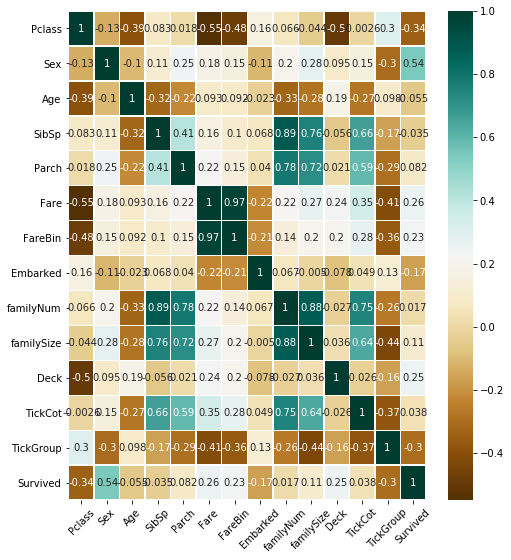

In [39]:
# 用熱力圖看一下
plt.figure(figsize=(8,9))
sns.heatmap(train_df[feature2].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

In [41]:
# 這幾項要刪掉 相關性低 'familyNum','SibSp','TickCot'
feature = ['Pclass','Sex','Age','Fare','FareBin','Embarked','familySize','Deck','TickGroup']
train_df[feature].head()

,Pclass,Sex,Age,Fare,FareBin,Embarked,familySize,Deck,TickGroup
0,3,0,22.0,7.2500,0,2,1,0,1
1,1,1,38.0,71.2833,1,0,1,1,1
2,3,1,26.0,7.9250,0,2,0,0,1
3,1,1,35.0,53.1000,1,2,1,1,0
4,3,0,35.0,8.0500,0,2,0,0,1


In [113]:
# 四除那幾項後，把幾個高相關項目用獨熱編碼合併起來

def one_hot(train_df):
    fullSel = train_df[feature]
    fullSel=pd.get_dummies(fullSel)

    ffull = train_df[feature]
    PclassDf=pd.get_dummies(ffull['Pclass'],prefix='Pclass')
    TickGroupDf=pd.get_dummies(ffull['TickGroup'],prefix='TickGroup')
    familySizeDf=pd.get_dummies(ffull['familySize'],prefix='familySize')

    fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,familySizeDf],axis=1)

    return fullSel

fullSel = one_hot(train_df)

train_x = fullSel
train_y = train_df['Survived']
test_x  = one_hot(test_df)

In [42]:
# 建立交叉驗證模型
def model_cv(model, X, y, cv_folds=5, early_stopping_rounds=50, seed=0):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X, label=y)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='auc', seed=seed, callbacks=[
            xgb.callback.print_evaluation(show_stdv=False),
            xgb.callback.early_stop(early_stopping_rounds)
       ])
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)
    return num_round_best

# 參數調整用
def gridsearch_cv(model, test_param, X, y, cv=5):
    from sklearn.model_selection import GridSearchCV
    gsearch = GridSearchCV(estimator=model, param_grid=test_param, scoring='roc_auc', n_jobs=4, cv=cv)
    gsearch.fit(X, y)
    print('CV Results: ', gsearch.cv_results_)
    print('Best Params: ', gsearch.best_params_)
    print('Best Score: ', gsearch.best_score_)
    return gsearch.best_params_

In [62]:
train_x = train_df[feature]
train_y = train_df['Survived']
test_x  = test_df[feature]

# 建立初始Model
num_round = 500
seed = 0
max_depth = 7
min_child_weight = 5
gamma = 0

# subsample = 0.7
# colsample_bytree = 0.5

subsample = 0.8 # 乍看結果比較好
colsample_bytree = 0.8 

scale_pos_weight = 1
reg_alpha = 1
reg_lambda = 1e-5
learning_rate = 0.1
model = XGBClassifier(learning_rate=learning_rate, n_estimators=num_round, max_depth=max_depth,
                      min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, reg_alpha=reg_alpha,
                      reg_lambda=reg_lambda, colsample_bytree=colsample_bytree, objective='binary:logistic',
                      nthread=4, scale_pos_weight=scale_pos_weight, seed=seed)

num_round = model_cv(model, train_x, train_y)

[0]	train-auc:0.869424	test-auc:0.844023
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[1]	train-auc:0.875751	test-auc:0.857781
[2]	train-auc:0.880287	test-auc:0.864256
[3]	train-auc:0.882301	test-auc:0.863238
[4]	train-auc:0.884238	test-auc:0.865091
[5]	train-auc:0.887043	test-auc:0.861067
[6]	train-auc:0.890806	test-auc:0.86463
[7]	train-auc:0.891279	test-auc:0.864626
[8]	train-auc:0.893659	test-auc:0.863681
[9]	train-auc:0.89564	test-auc:0.866427
[10]	train-auc:0.897539	test-auc:0.867056
[11]	train-auc:0.898733	test-auc:0.867873
[12]	train-auc:0.900136	test-auc:0.867953
[13]	train-auc:0.899787	test-auc:0.868709
[14]	train-auc:0.900958	test-auc:0.869642
[15]	train-auc:0.903062	test-auc:0.870143
[16]	train-auc:0.904481	test-auc:0.8697
[17]	train-auc:0.905872	test-auc:0.870929
[18]	train-auc:0.907304	test-auc:0.870281
[19]	train-auc:0.908292	test-auc:0.870585
[20]	train-auc:0.909007	test-auc:

[191]	train-auc:0.9615	test-auc:0.8847
[192]	train-auc:0.961513	test-auc:0.884333
[193]	train-auc:0.961571	test-auc:0.884487
[194]	train-auc:0.961664	test-auc:0.884277
[195]	train-auc:0.961804	test-auc:0.884708
[196]	train-auc:0.961966	test-auc:0.884717
[197]	train-auc:0.962005	test-auc:0.884873
[198]	train-auc:0.962147	test-auc:0.884949
[199]	train-auc:0.962279	test-auc:0.884876
[200]	train-auc:0.962365	test-auc:0.885127
[201]	train-auc:0.962443	test-auc:0.884816
[202]	train-auc:0.962485	test-auc:0.885015
[203]	train-auc:0.962534	test-auc:0.885099
[204]	train-auc:0.962691	test-auc:0.884956
[205]	train-auc:0.962709	test-auc:0.885172
[206]	train-auc:0.962839	test-auc:0.885531
[207]	train-auc:0.963016	test-auc:0.885493
[208]	train-auc:0.962982	test-auc:0.885189
[209]	train-auc:0.963023	test-auc:0.885224
[210]	train-auc:0.963125	test-auc:0.885449
[211]	train-auc:0.96328	test-auc:0.884986
[212]	train-auc:0.963345	test-auc:0.884692
[213]	train-auc:0.963461	test-auc:0.885471
[214]	train-auc:

In [ ]:
param_test1 = {
    'max_depth': range(5, 8, 1),
    'min_child_weight': range(3, 6, 1)
    
    'gamma': [i / 10.0 for i in range(0, 5)]
    'subsample': [i / 10.0 for i in range(5, 10)],
    'colsample_bytree': [i / 10.0 for i in range(5, 10)]
    'scale_pos_weight': [i for i in range(1, 10, 2)]
}

In [55]:

param_test1 = {
        'scale_pos_weight': [i for i in range(1, 10, 2)]
}


gridsearch_cv(model, param_test1, train_x, train_y)

CV Results:  {'mean_fit_time': array([0.69830956, 0.8121706 , 0.83771887, 0.85492272, 0.81685972]), 'std_fit_time': array([0.00531467, 0.00706869, 0.00562977, 0.00508229, 0.07836438]), 'mean_score_time': array([0.00592408, 0.00598373, 0.00514455, 0.00498657, 0.004496  ]), 'std_score_time': array([0.00197711, 0.00063053, 0.00271029, 0.00252302, 0.00296645]), 'param_scale_pos_weight': masked_array(data=[1, 3, 5, 7, 9],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'scale_pos_weight': 1}, {'scale_pos_weight': 3}, {'scale_pos_weight': 5}, {'scale_pos_weight': 7}, {'scale_pos_weight': 9}], 'split0_test_score': array([0.88906456, 0.88089592, 0.87931489, 0.87997365, 0.88577075]), 'split1_test_score': array([0.82286096, 0.83041444, 0.82907754, 0.82372995, 0.82453209]), 'split2_test_score': array([0.89839572, 0.89846257, 0.8953877 , 0.89177807, 0.89284759]), 'split3_test_score': array([0.88877005, 0.88128342, 0.87754011, 0.8

{'scale_pos_weight': 1}

In [63]:
# Export result
model.fit(train_x, train_y)
test_pred = model.predict(test_x)
pred = test_df[['PassengerId']]

# pred['Survived'] = test_pred  # 這個可能有異常先改掉
pred.loc[:,('Survived')] = test_pred
pred.to_csv(r'C:\Users\arthur.chang\Desktop\output_High.csv', index=None)